## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'cwt-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_cwt_1e5rawre_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os
import sys

sys.path.append('/scratch/users/lievhenry/hierarchical-bayesian-model-validation/utilities')

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

print(os.getcwd())
print(ROOT_DIR)
print(CWD)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawre/cwt/statement_2
/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation
/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawre/cwt/statement_2


'/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawre/cwt/statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


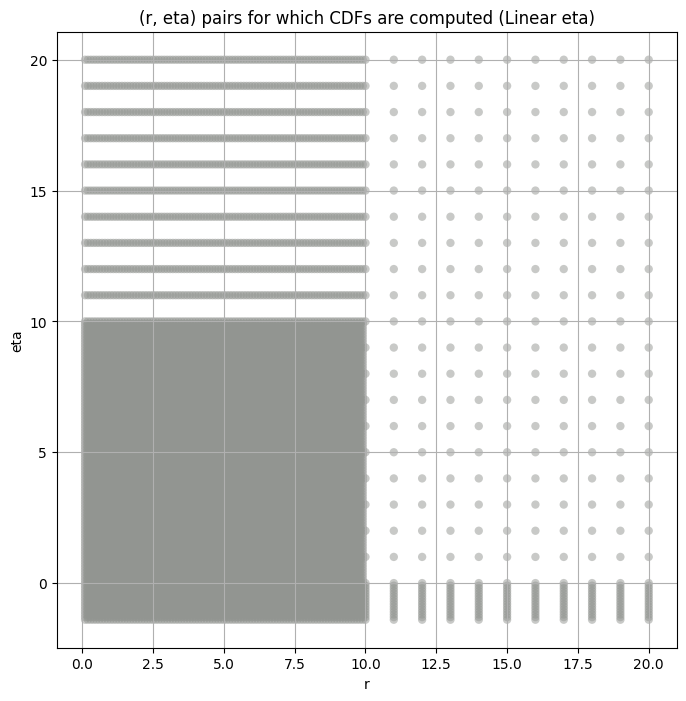

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,9.304438e+08,8.450694e+08,1.021509e+09,11.473392,9.685302,14.099255,57419247.0
5,2.322291e+09,2.175008e+09,2.474092e+09,4.320653,3.779684,4.902254,57419247.0
8,1.710829e+09,1.607269e+09,1.818124e+09,3.818770,3.301206,4.359999,57419247.0
11,1.497775e+09,1.413093e+09,1.583780e+09,2.941873,2.638872,3.259851,57419247.0
14,3.499311e+08,3.208751e+08,3.802060e+08,8.869140,7.774240,10.038319,57419247.0
18,7.146146e+07,6.552033e+07,7.788669e+07,9.265937,7.092387,12.380862,57419247.0
21,2.790665e+07,2.514312e+07,3.095791e+07,14.160639,10.133566,20.465754,57419247.0
24,2.332932e+07,2.041269e+07,2.649432e+07,23.594398,19.808994,27.871246,57419247.0
27,1.140600e+07,9.829747e+06,1.310639e+07,29.102272,24.468296,34.380184,57419247.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,9.304438e+08,9.304439e+08,9.017939e+08,8.818900e+08,8.644082e+08,8.484132e+08,8.195105e+08,7.935359e+08,7.697836e+08,7.478289e+08,7.273641e+08,6.730259e+08
5,2.322291e+09,2.322291e+09,2.286694e+09,2.257126e+09,2.230384e+09,2.205565e+09,2.160123e+09,2.118764e+09,2.080468e+09,2.044637e+09,2.010849e+09,1.919017e+09
8,1.710829e+09,1.710829e+09,1.685650e+09,1.663971e+09,1.644313e+09,1.626237e+09,1.593635e+09,1.564429e+09,1.537720e+09,1.512967e+09,1.489746e+09,1.426935e+09
11,1.497775e+09,1.497775e+09,1.482960e+09,1.469706e+09,1.457265e+09,1.445423e+09,1.423109e+09,1.402219e+09,1.382466e+09,1.363659e+09,1.345669e+09,1.295633e+09
14,3.499311e+08,3.499311e+08,3.417864e+08,3.350210e+08,3.289517e+08,3.233757e+08,3.133043e+08,3.042924e+08,2.960706e+08,2.884807e+08,2.814165e+08,2.626245e+08
18,7.146146e+07,7.146146e+07,6.905330e+07,6.740460e+07,6.602397e+07,6.481264e+07,6.272512e+07,6.093937e+07,5.936372e+07,5.794580e+07,5.665191e+07,5.331830e+07
21,2.790665e+07,2.790665e+07,2.661240e+07,2.578298e+07,2.510857e+07,2.452949e+07,2.355534e+07,2.274402e+07,2.204320e+07,2.142314e+07,2.086476e+07,1.944168e+07
24,2.332932e+07,2.332932e+07,2.220328e+07,2.133863e+07,2.059198e+07,1.992478e+07,1.875905e+07,1.775630e+07,1.687308e+07,1.608275e+07,1.536773e+07,1.356372e+07
27,1.140600e+07,1.140600e+07,1.079163e+07,1.031730e+07,9.908300e+06,9.543398e+06,8.907322e+06,8.362116e+06,7.883323e+06,7.456448e+06,7.071602e+06,6.105964e+06


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,9.304438e+08,8.450694e+08,1.021509e+09,11.473392,9.685302,14.099255,57419247.0,0.023567,0.1,0.0,0.000131,0.0,9.304438e+08,0.000179
5,2.322291e+09,2.175008e+09,2.474092e+09,4.320653,3.779684,4.902254,57419247.0,0.032170,0.2,-0.1,41246.286869,25.0,2.286694e+09,0.000179
8,1.710829e+09,1.607269e+09,1.818124e+09,3.818770,3.301206,4.359999,57419247.0,0.023749,0.2,0.5,6926.284382,50.0,1.663971e+09,0.000179
11,1.497775e+09,1.413093e+09,1.583780e+09,2.941873,2.638872,3.259851,57419247.0,0.030077,0.2,0.1,15603.529966,25.0,1.482960e+09,0.000179
14,3.499311e+08,3.208751e+08,3.802060e+08,8.869140,7.774240,10.038319,57419247.0,0.017438,0.2,-0.5,22604.920635,25.0,3.417864e+08,0.000179
18,7.146146e+07,6.552033e+07,7.788669e+07,9.265937,7.092387,12.380862,57419247.0,0.016094,0.2,-0.2,1728.882423,0.0,7.146146e+07,0.000179
21,2.790665e+07,2.514312e+07,3.095791e+07,14.160639,10.133566,20.465754,57419247.0,0.014833,0.2,-0.4,1190.839701,50.0,2.578298e+07,0.000179
24,2.332932e+07,2.041269e+07,2.649432e+07,23.594398,19.808994,27.871246,57419247.0,0.008031,0.2,-1.0,16573.162660,0.0,2.332932e+07,0.000179
27,1.140600e+07,9.829747e+06,1.310639e+07,29.102272,24.468296,34.380184,57419247.0,0.009755,0.2,-1.1,13761.527778,75.0,9.908300e+06,0.000179


## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,9.304438e+08,8.450694e+08,1.021509e+09,11.473392,9.685302,14.099255,57419247.0,0.023567,0.1,0.0,0.000131,0.0,9.304438e+08,0.000179,0.021626,0.13,-0.40,6.042405,0.0,3942
5,2.322291e+09,2.175008e+09,2.474092e+09,4.320653,3.779684,4.902254,57419247.0,0.032170,0.2,-0.1,41246.286869,25.0,2.322291e+09,0.000179,0.031661,0.20,-0.12,44359.719905,0.0,1752
8,1.710829e+09,1.607269e+09,1.818124e+09,3.818770,3.301206,4.359999,57419247.0,0.023749,0.2,0.5,6926.284382,50.0,1.663971e+09,0.000179,0.023108,0.22,0.30,50261.516256,50.0,3504
11,1.497775e+09,1.413093e+09,1.583780e+09,2.941873,2.638872,3.259851,57419247.0,0.030077,0.2,0.1,15603.529966,25.0,1.497775e+09,0.000179,0.029523,0.21,0.00,44601.604532,0.0,2217
14,3.499311e+08,3.208751e+08,3.802060e+08,8.869140,7.774240,10.038319,57419247.0,0.017438,0.2,-0.5,22604.920635,25.0,3.499311e+08,0.000179,0.016949,0.20,-0.51,24026.220220,0.0,6651
18,7.146146e+07,6.552033e+07,7.788669e+07,9.265937,7.092387,12.380862,57419247.0,0.016094,0.2,-0.2,1728.882423,0.0,7.146146e+07,0.000179,0.015092,0.25,-0.50,85073.171429,0.0,7884
21,2.790665e+07,2.514312e+07,3.095791e+07,14.160639,10.133566,20.465754,57419247.0,0.014833,0.2,-0.4,1190.839701,50.0,2.790665e+07,0.000179,0.011246,0.26,-0.70,96183.777627,0.0,14018
24,2.332932e+07,2.041269e+07,2.649432e+07,23.594398,19.808994,27.871246,57419247.0,0.008031,0.2,-1.0,16573.162660,0.0,2.332932e+07,0.000179,0.007181,0.20,-0.98,14660.080761,0.0,35482
27,1.140600e+07,9.829747e+06,1.310639e+07,29.102272,24.468296,34.380184,57419247.0,0.009755,0.2,-1.1,13761.527778,75.0,9.543397e+06,0.000179,0.009381,0.20,-1.09,12335.237458,100.0,21027


## Comparing Empirical and Computed CDF/PDF

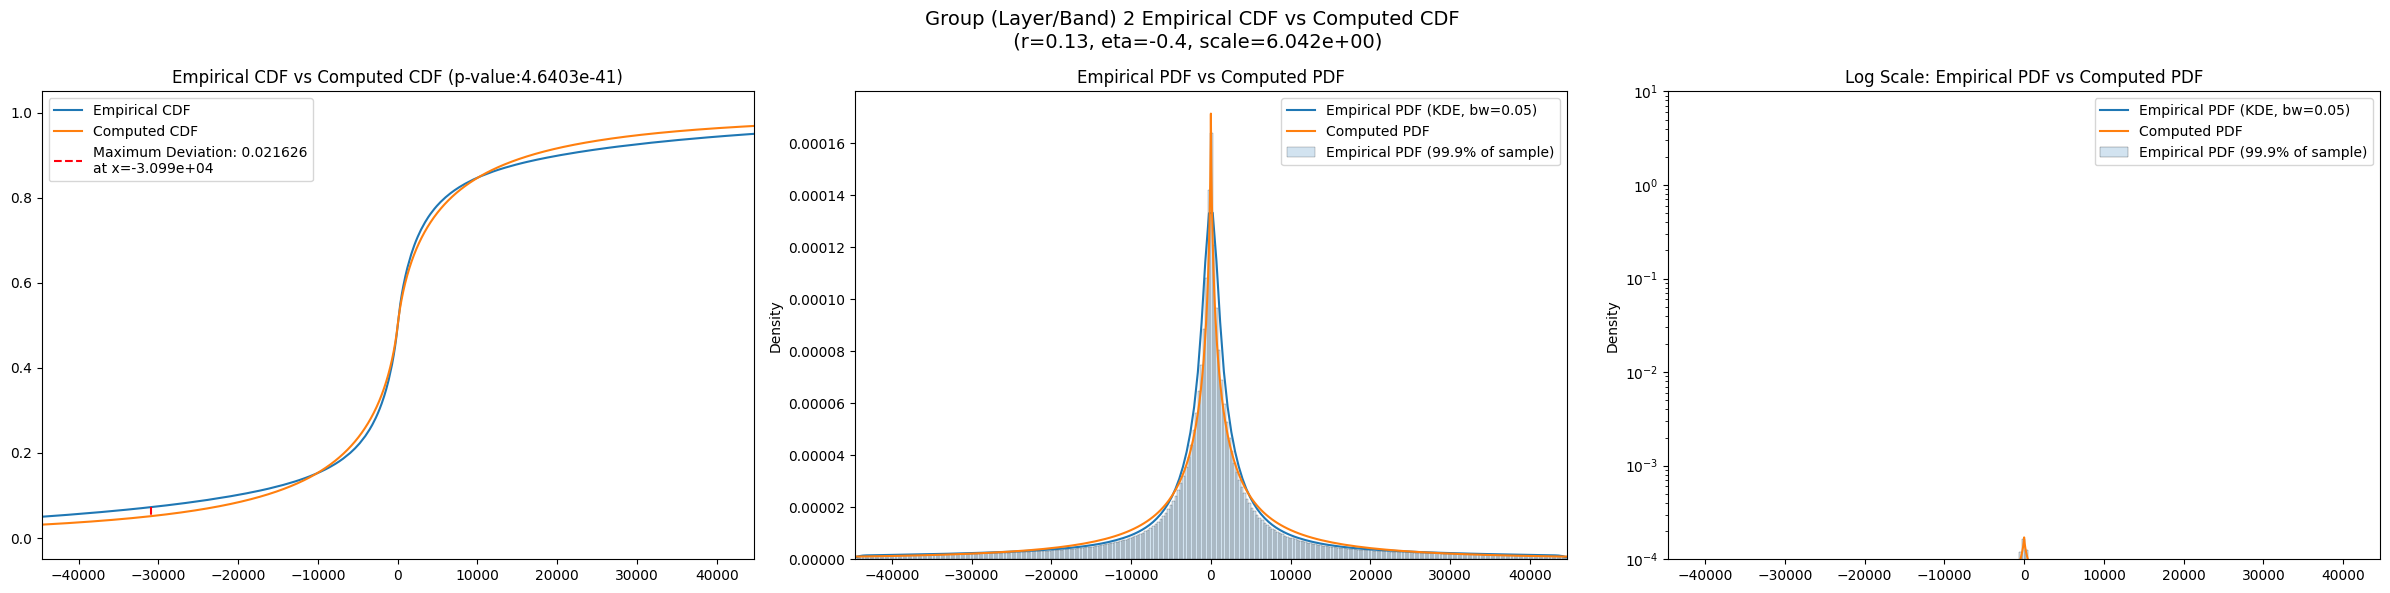

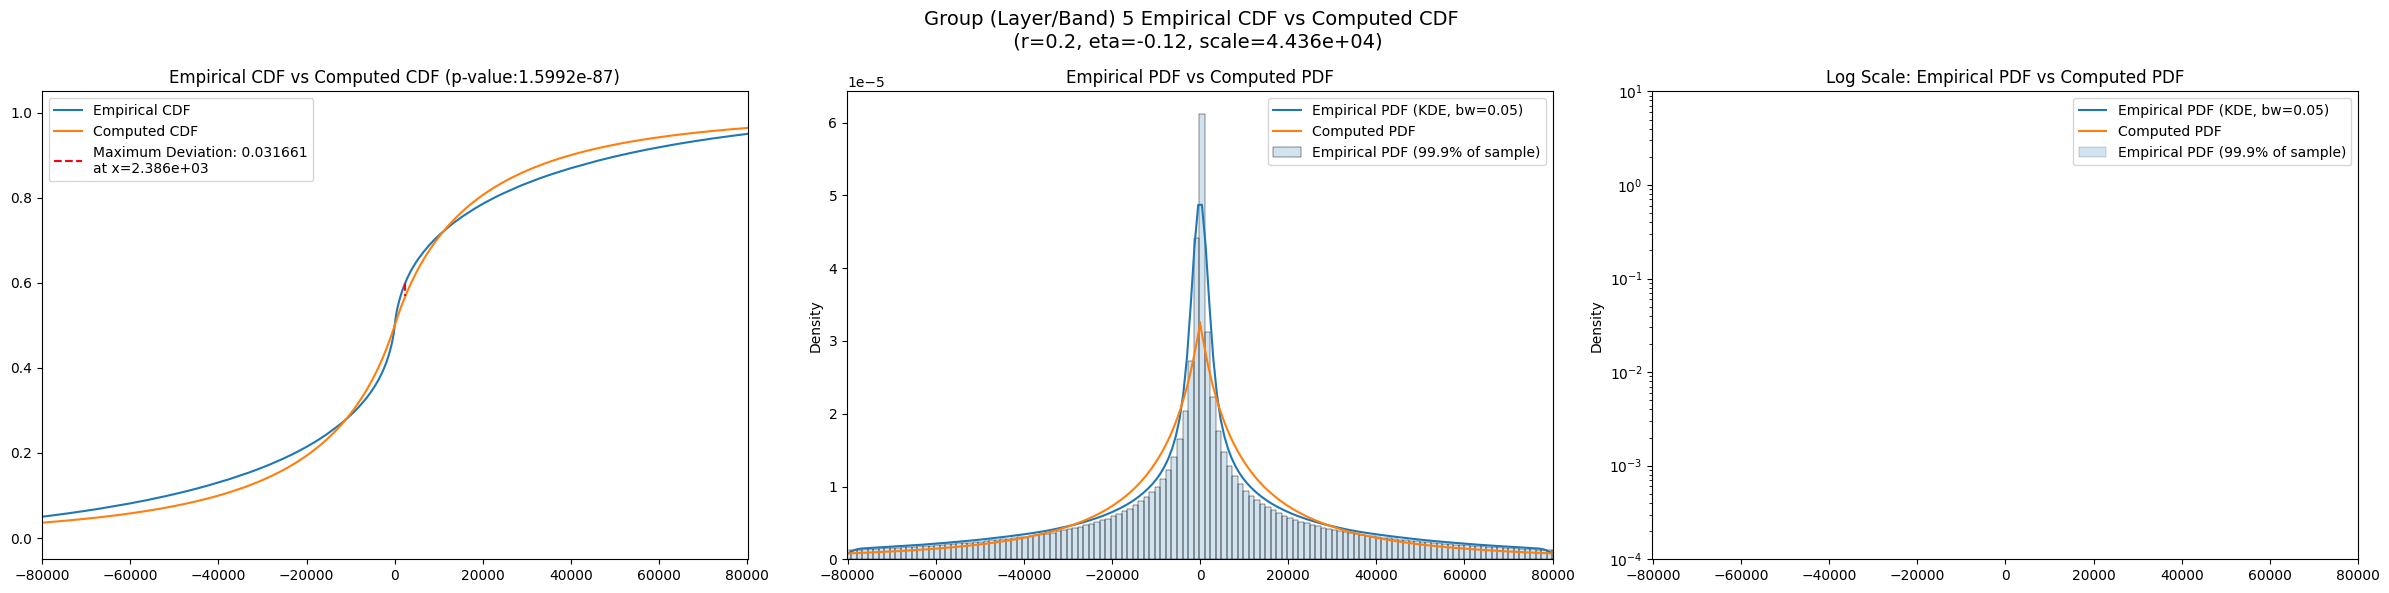

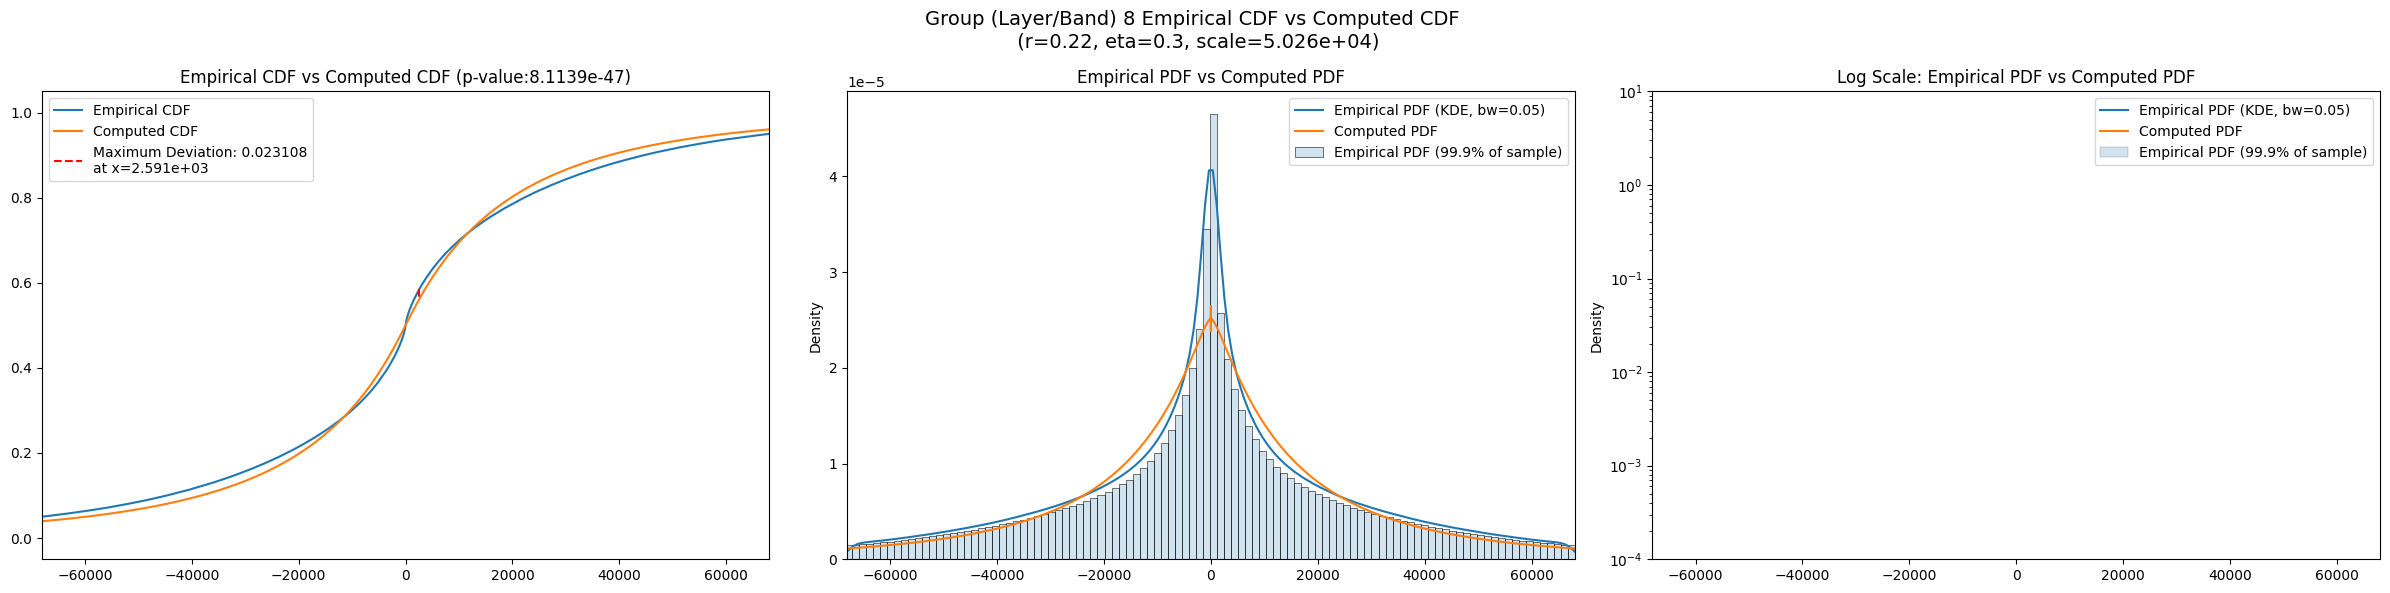

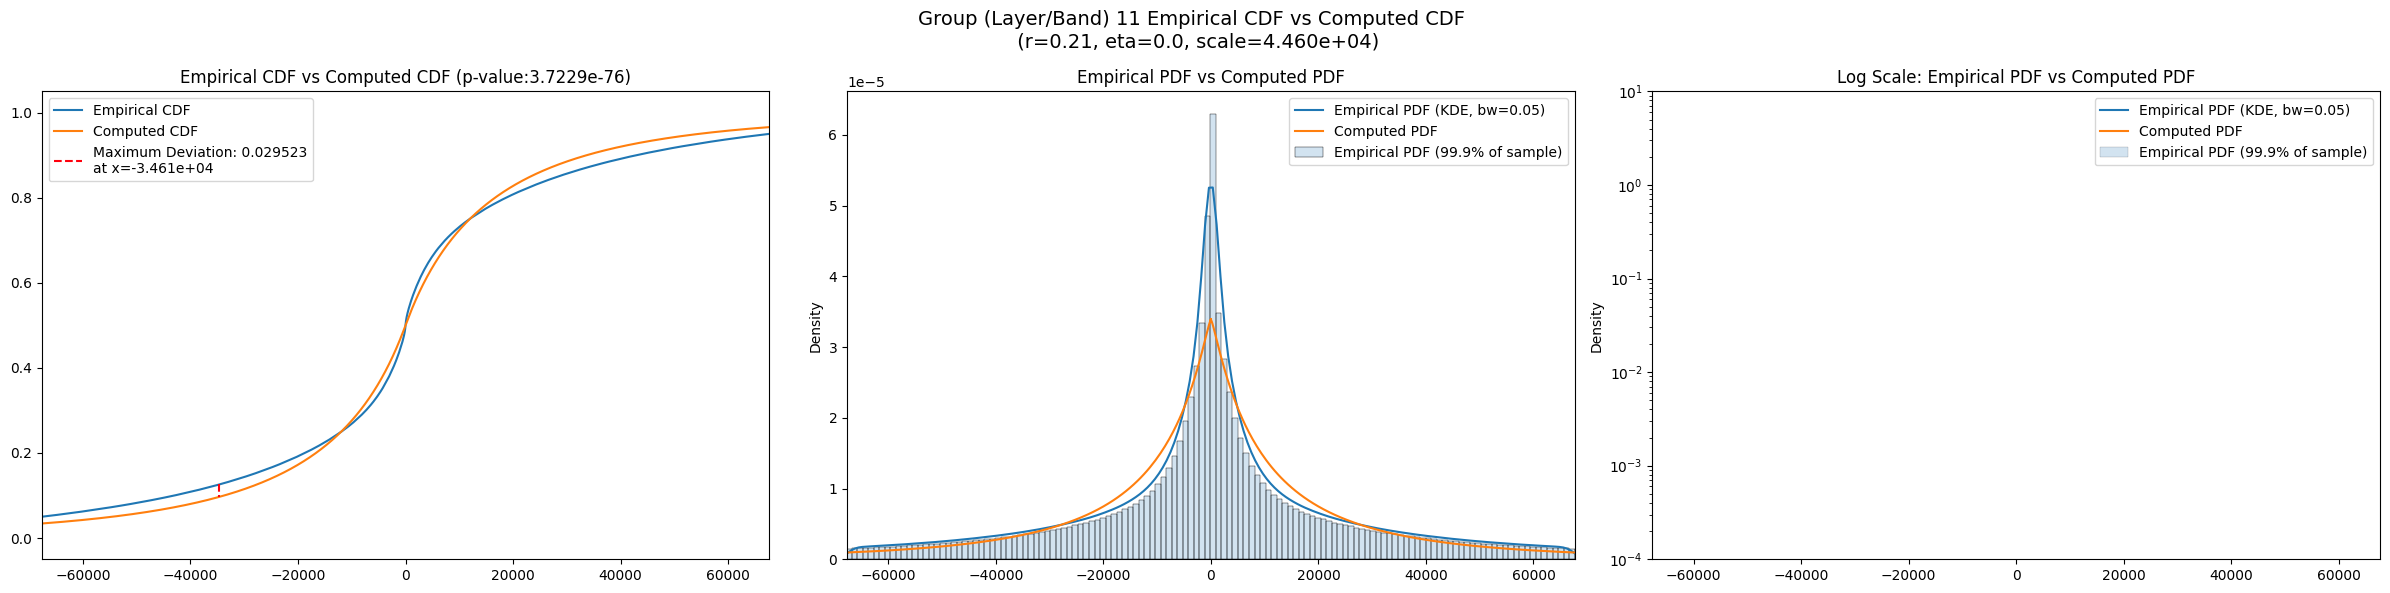

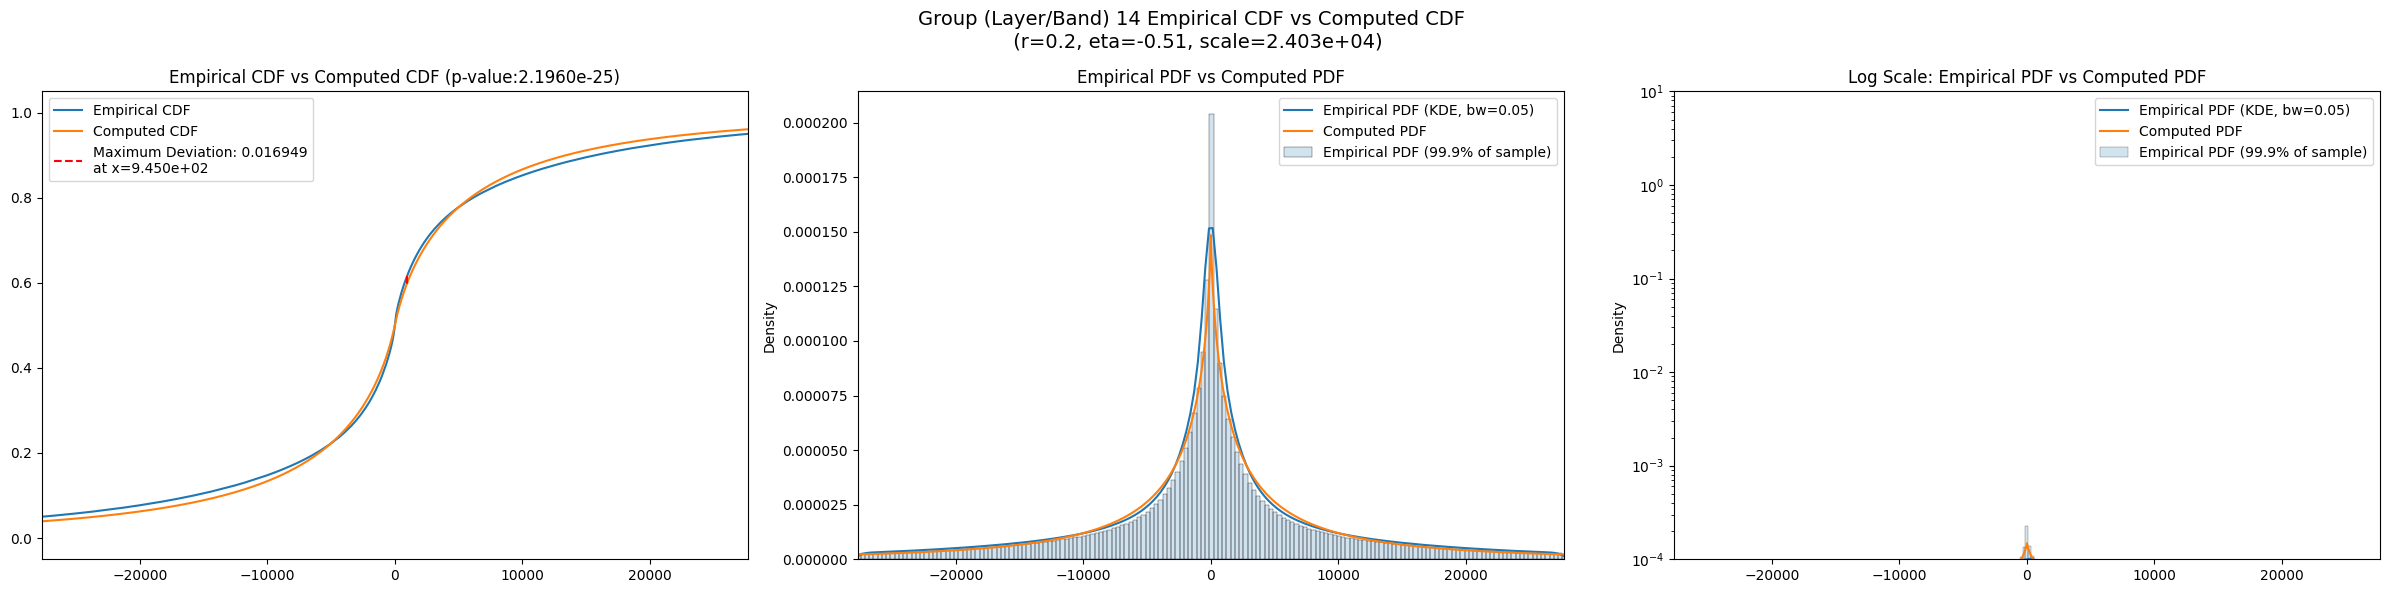

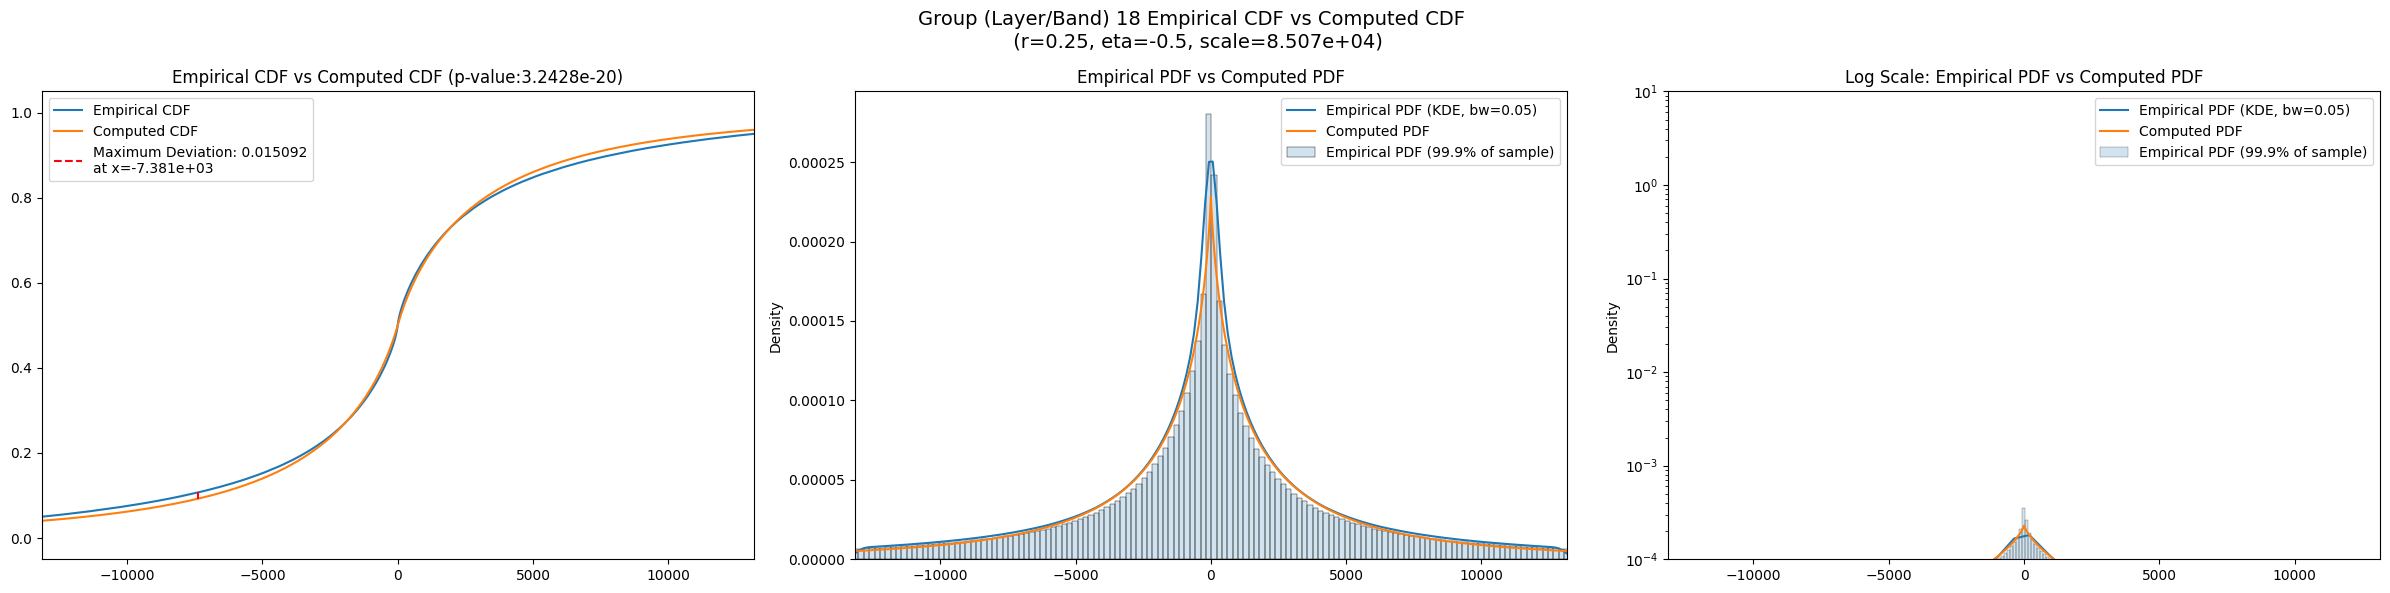

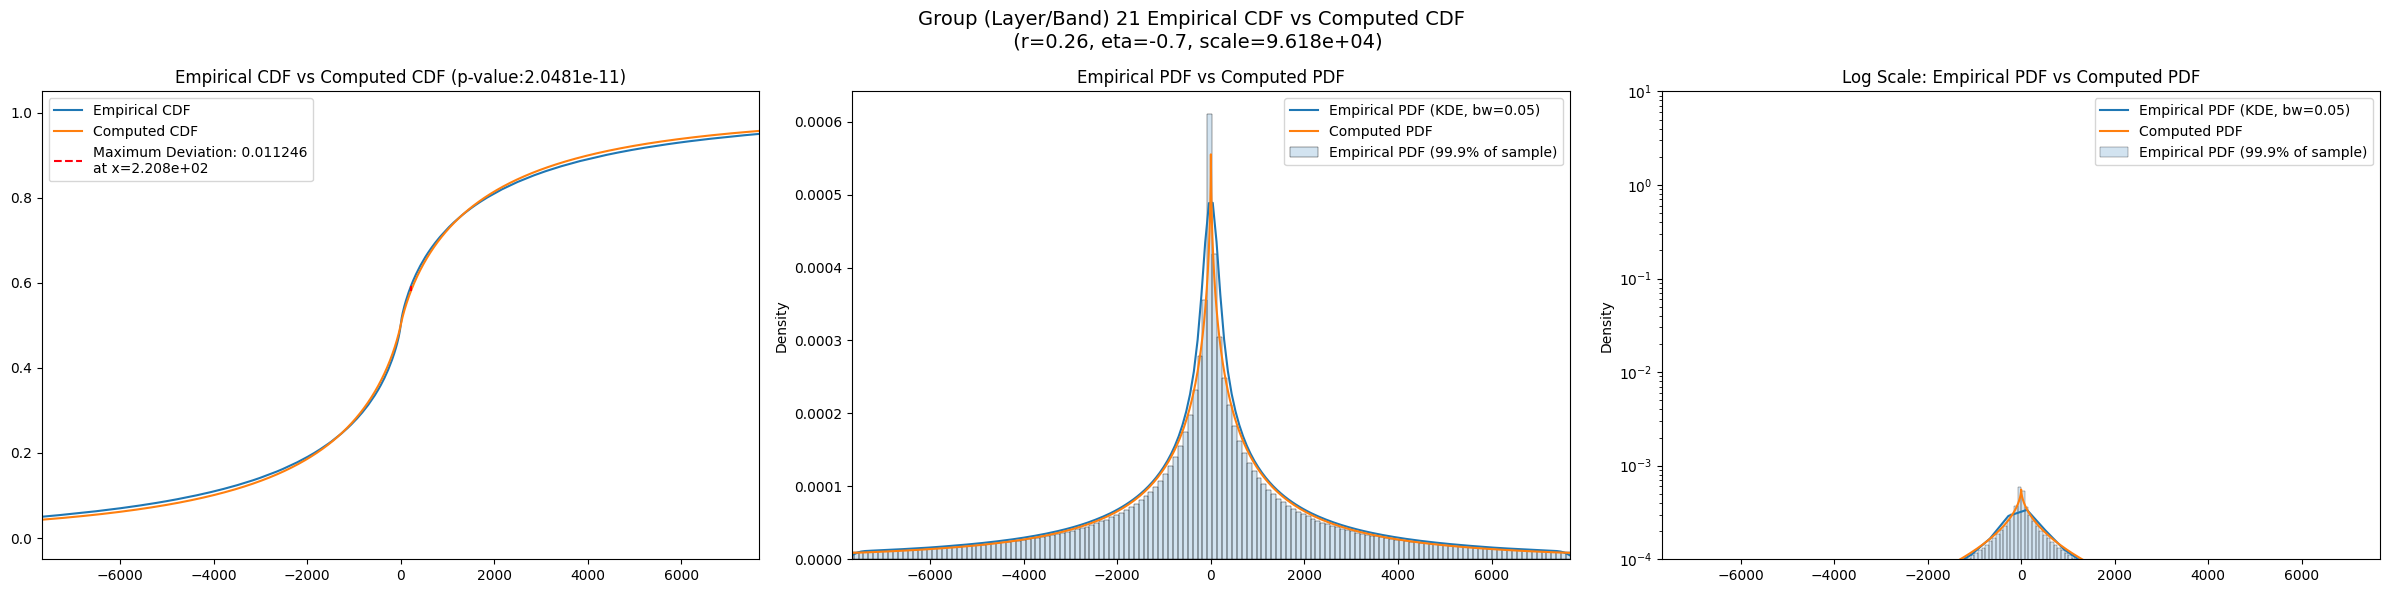

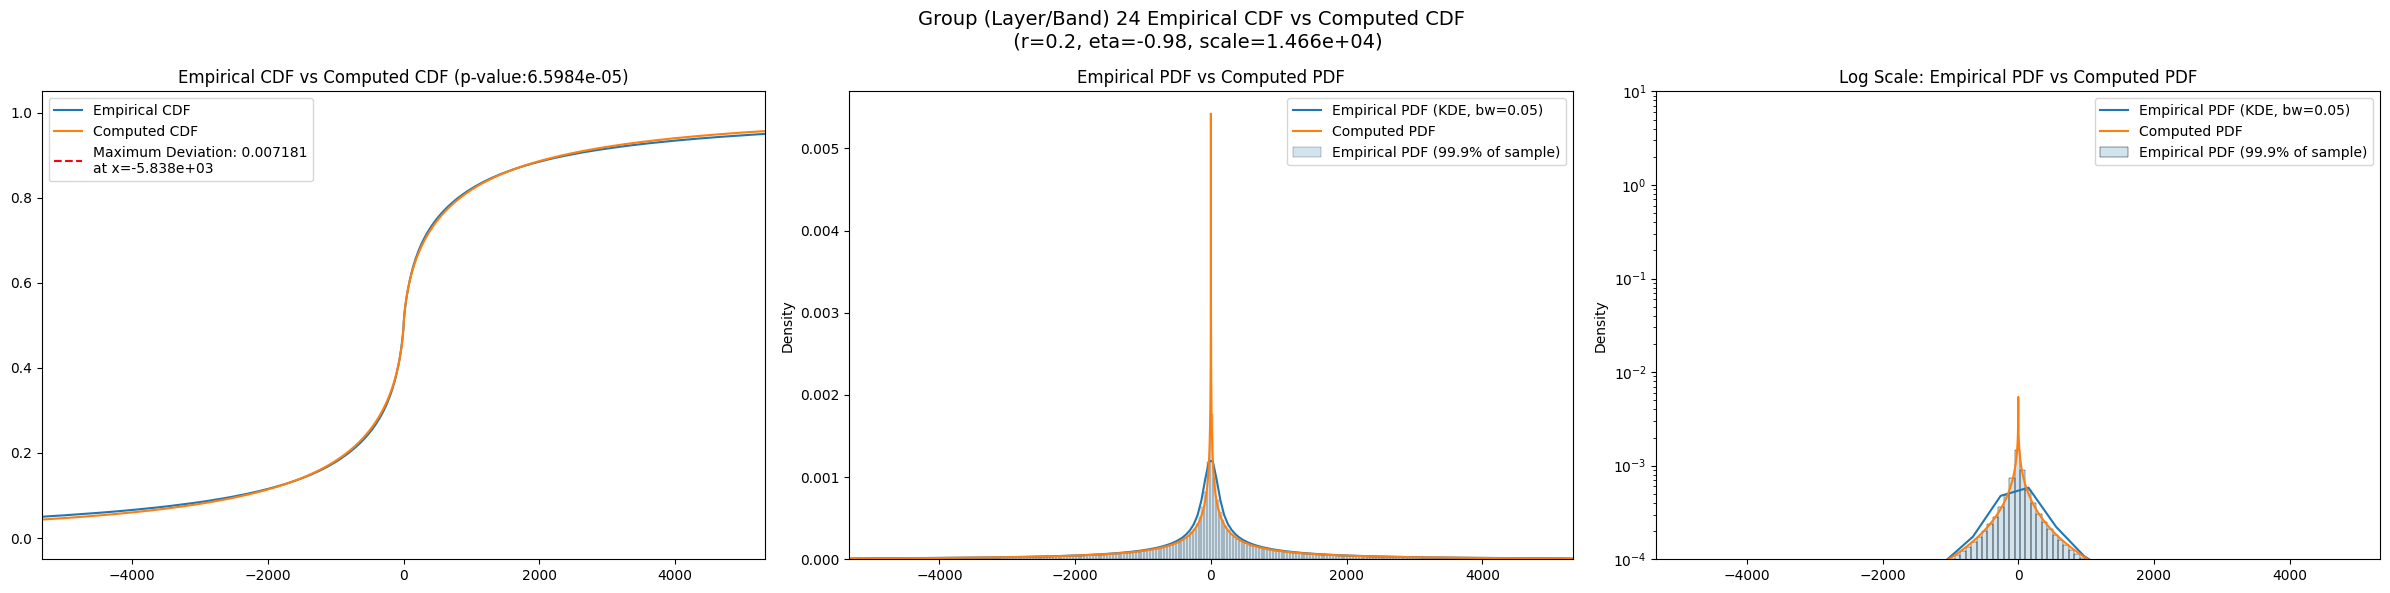

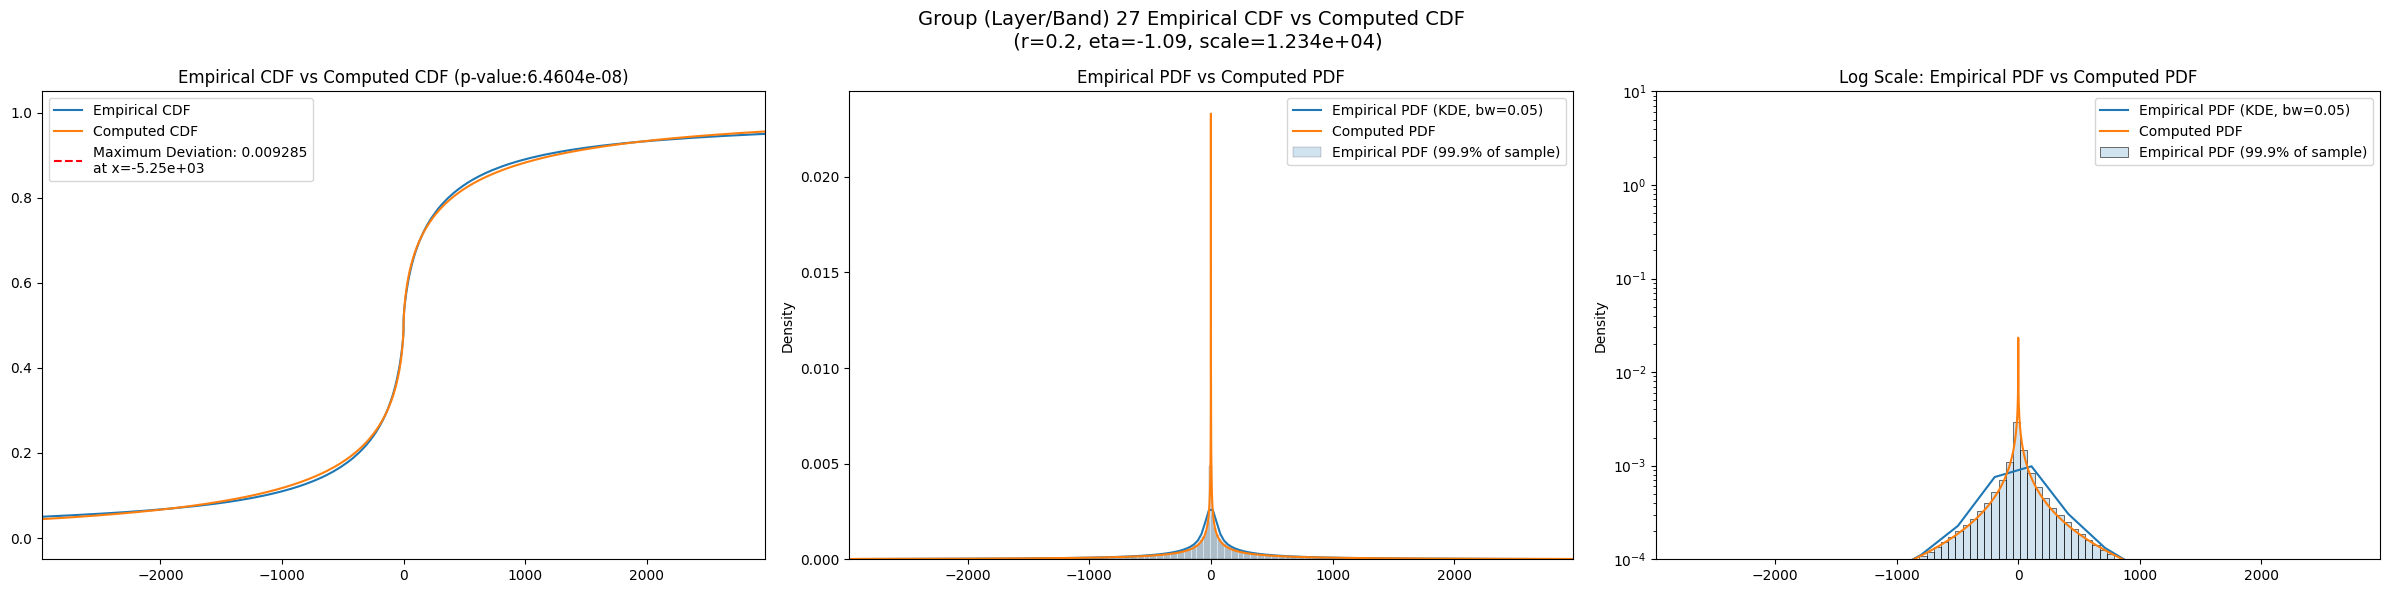

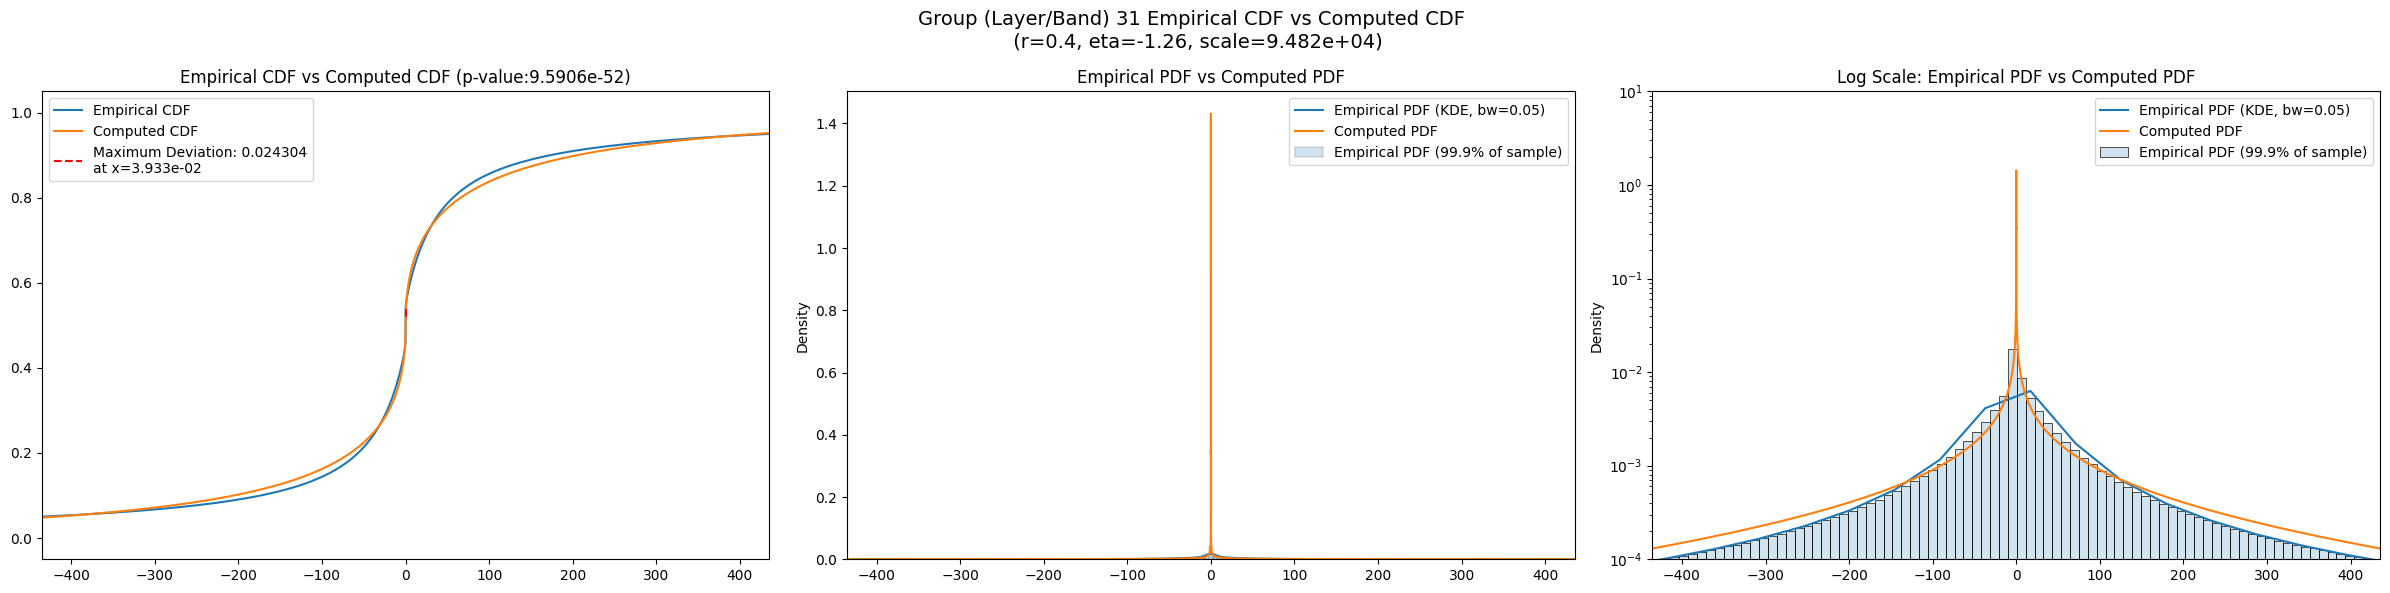

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,9.304438e+08,8.450694e+08,1.021509e+09,11.473392,9.685302,14.099255,57419247.0,0.023567,0.1,0.0,...,8541.1200,0.092263,0.0,7613.3200,0.068122,0.0,5764.0600,0.064787,0.0,0.0
5,2.322291e+09,2.175008e+09,2.474092e+09,4.320653,3.779684,4.902254,57419247.0,0.032170,0.2,-0.1,...,26246.0000,0.075165,0.0,22129.2000,0.051368,0.0,17659.4000,0.055099,0.0,0.0
8,1.710829e+09,1.607269e+09,1.818124e+09,3.818770,3.301206,4.359999,57419247.0,0.023749,0.2,0.5,...,26249.1000,0.057090,0.0,22419.9000,0.032155,0.0,18239.6000,0.037237,0.0,0.0
11,1.497775e+09,1.413093e+09,1.583780e+09,2.941873,2.638872,3.259851,57419247.0,0.030077,0.2,0.1,...,22255.8000,0.073700,0.0,19093.4000,0.047785,0.0,15225.2000,0.050943,0.0,0.0
14,3.499311e+08,3.208751e+08,3.802060e+08,8.869140,7.774240,10.038319,57419247.0,0.017438,0.2,-0.5,...,7788.1300,0.078905,0.0,6734.3000,0.052838,0.0,5267.4400,0.054007,0.0,0.0
18,7.146146e+07,6.552033e+07,7.788669e+07,9.265937,7.092387,12.380862,57419247.0,0.016094,0.2,-0.2,...,4381.1300,0.066367,0.0,3787.3000,0.040114,0.0,2975.2800,0.041949,0.0,0.0
21,2.790665e+07,2.514312e+07,3.095791e+07,14.160639,10.133566,20.465754,57419247.0,0.014833,0.2,-0.4,...,2335.8300,0.071142,0.0,2013.3000,0.045590,0.0,1570.6700,0.047010,0.0,0.0
24,2.332932e+07,2.041269e+07,2.649432e+07,23.594398,19.808994,27.871246,57419247.0,0.008031,0.2,-1.0,...,1039.9900,0.091000,0.0,905.4330,0.067074,0.0,684.4590,0.065842,0.0,0.0
27,1.140600e+07,9.829747e+06,1.310639e+07,29.102272,24.468296,34.380184,57419247.0,0.009755,0.2,-1.1,...,482.0210,0.091966,0.0,421.6460,0.069071,0.0,313.9270,0.067128,0.0,0.0


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.023567,0.000179,0.021626,0.092263,0.068122,0.064787
5,0.032170,0.000179,0.031661,0.075165,0.051368,0.055099
8,0.023749,0.000179,0.023108,0.057090,0.032155,0.037237
11,0.030077,0.000179,0.029523,0.073700,0.047785,0.050943
14,0.017438,0.000179,0.016949,0.078905,0.052838,0.054007
18,0.016094,0.000179,0.015092,0.066367,0.040114,0.041949
21,0.014833,0.000179,0.011246,0.071142,0.045590,0.047010
24,0.008031,0.000179,0.007181,0.091000,0.067074,0.065842
27,0.009755,0.000179,0.009381,0.091966,0.069071,0.067128


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,9.304438e+08,0.021626,0.13,-0.40,6.042405,0.0
5,2.322291e+09,0.031661,0.20,-0.12,44359.719905,0.0
8,1.663971e+09,0.023108,0.22,0.30,50261.516256,50.0
11,1.497775e+09,0.029523,0.21,0.00,44601.604532,0.0
14,3.499311e+08,0.016949,0.20,-0.51,24026.220220,0.0
18,7.146146e+07,0.015092,0.25,-0.50,85073.171429,0.0
21,2.790665e+07,0.011246,0.26,-0.70,96183.777627,0.0
24,2.332932e+07,0.007181,0.20,-0.98,14660.080761,0.0
27,9.543397e+06,0.009381,0.20,-1.09,12335.237458,100.0
